In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from plot_keras_history import show_history, plot_history
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16


In [13]:
dfcl = pd.read_csv('dataCNN.csv')

# Data augmentation 

In [15]:
dfcl

,image,subcategory_1,label
0,Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,Images/7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,Images/64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,Images/d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,Images/6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4
...,...,...,...
1045,Images/958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0
1046,Images/fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0
1047,Images/5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0
1048,Images/c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0


In [16]:
## MODELE

In [17]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [18]:
# Pour mélanger les images, classées initalement par classe
data_a = dfcl.sample(frac=1, random_state=42).reset_index(drop=True)

In [22]:

def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(dfcl['image'])) :
        img = (load_img(
            dfcl['image'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct(dfcl)
print(images_np.shape)
images_np_test = image_prep_fct(dfcl)
print(images_np_test.shape)

C:\Users\boukh\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(1050, 224, 224, 3)
(1050, 224, 224, 3)


In [23]:



X = images_np
y = to_categorical(dfcl['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(787, 224, 224, 3)

In [25]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image', y_col='subcategory_1',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [26]:



datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data_a, datagen_train, data_type='training')
val_flow = data_flow_fct(data_a, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 788 validated image filenames belonging to 7 classes.
Found 262 validated image filenames belonging to 7 classes.
Found 158 validated image filenames belonging to 7 classes.


In [29]:


model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [30]:
history1 = model2.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)


Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 5.0421 - accuracy: 0.4676
Epoch 1: val_loss improved from inf to 1.28636, saving model to .\model2_best_weights.h5
13/13 [==============================] - 43s 3s/step - loss: 5.0421 - accuracy: 0.4676 - val_loss: 1.2864 - val_accuracy: 0.7567
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 1.8662 - accuracy: 0.7039
Epoch 2: val_loss did not improve from 1.28636
13/13 [==============================] - 45s 3s/step - loss: 1.8662 - accuracy: 0.7039 - val_loss: 1.3150 - val_accuracy: 0.7148
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 1.1742 - accuracy: 0.7535
Epoch 3: val_loss improved from 1.28636 to 0.97967, saving model to .\model2_best_weights.h5
13/13 [==============================] - 44s 3s/step - loss: 1.1742 - accuracy: 0.7535 - val_loss: 0.9797 - val_accuracy: 0.7909
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 0.8788 - accuracy: 0.7865
Epoch 4:

In [31]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

25/25 [==============================] - 45s 2s/step - loss: 0.4384 - accuracy: 0.8642
Training Accuracy   : 0.8642

2/9 [=====>........................] - ETA: 12s - loss: 0.3596 - accuracy: 0.8750

C:\Users\boukh\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


9/9 [==============================] - 16s 2s/step - loss: 0.3626 - accuracy: 0.8740
Validation Accuracy :  0.8740


In [32]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8511
Test Accuracy       :  0.9177


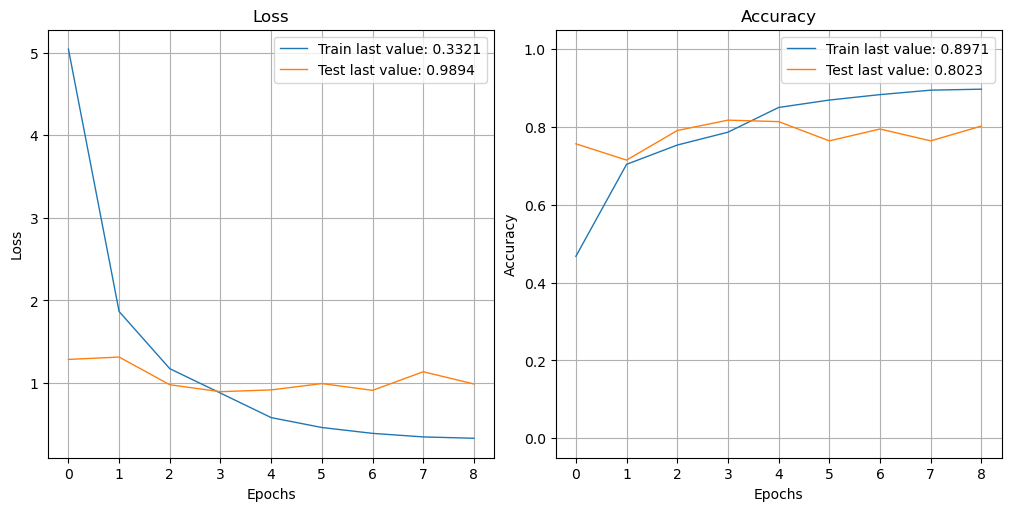

In [33]:

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

# Conclusion 

Le moteur de classification est possible.
Les résultats du score ARI démontre de meilleur résultat pour une approche avec les algorithmes Tf-idf + CNN.
Concernant la classification supervisée et le data augmentation. Un meilleur pourcentage de validation apparaît pour la data augmentation.
Piste améliorations : affiner les hyperparametres, ajout de nouvelle données par l'entrepris